In [1]:
import numpy as np
import pandas as pd
import operator
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV,LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.exceptions import DataConversionWarning
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras import metrics
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.regularizers import l1, l2
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras import backend as K
from keras.optimizers import SGD, Adam, Adadelta

Using TensorFlow backend.


In [2]:
# read data
data = pd.read_csv('dataset2_addfeatures.csv')
# sale price
SalePrice = data['SalePrice'].dropna()
y = np.log1p(SalePrice)
data = data.drop(['SalePrice','Id'],axis=1)
cols_categoric = data.select_dtypes(include = ["object"]).columns.tolist()
# number of training samples
n_train = SalePrice.shape[0]
# add total square footage
data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,MasVnrArea_absent,MiscVal_absent,OpenPorchSF_absent,PoolArea_absent,ScreenPorch_absent,TotalBsmtSF_absent,WoodDeckSF_absent,compPrice,compIndex,compPriceXcompIndex
0,856,854,0,3,706.0,0.0,1.0,0.0,150.0,0,...,0,1,0,1,1,0,1,75.920375,37.2,2824.237967
1,1262,0,0,3,978.0,0.0,0.0,1.0,284.0,0,...,1,1,1,1,1,0,0,63.907207,32.4,2070.593520
2,920,866,0,3,486.0,0.0,1.0,0.0,434.0,0,...,0,1,0,1,1,0,1,81.912811,37.2,3047.156573
3,961,756,0,3,216.0,0.0,1.0,0.0,540.0,272,...,1,1,0,1,1,0,1,71.113339,31.0,2204.513512
4,1145,1053,0,4,655.0,0.0,1.0,0.0,490.0,0,...,0,1,0,1,1,0,0,85.591085,36.4,3115.515497


In [3]:
# function dummifies categoric features
def get_custom_dummies(data,y,n_train):
    cols_categoric = data.select_dtypes(include = ["object"]).columns.tolist()
    cols_numeric = set(data.columns.tolist())-set(cols_categoric)
    df = data.loc[:,cols_numeric]
    for col in cols_categoric:        
        dummies = pd.get_dummies(data[[col]])
        idx_min_corr = np.argmin(np.abs(np.array([dummies[:n_train][subcol].corr(y) for subcol in dummies.columns.tolist()])))
        col_min_corr = dummies.columns.tolist()[idx_min_corr]
        df = pd.concat([df,dummies.drop(col_min_corr,axis=1)],axis=1)    
    return(df)

In [4]:
# dummify data
data = get_custom_dummies(data,y,n_train)
data = (data - data.mean())/data.std()
# drop duplicates
X = data[:n_train]
X = X.T.drop_duplicates().T
# find columns
cols = X.columns.tolist()
data = data.loc[:,cols]
X = data[:n_train]
X.head()

,BsmtFinSF_log,BsmtHalfBath,TotRmsAbvGrd,EnclosedPorch,GrLivArea,LotFrontage_log,BsmtFinSF,TotalBath,compPriceXcompIndex,YearBuilt,...,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Utilities_AllPub
0,0.734988,-0.249767,0.992109,-0.359678,0.426131,0.434517,0.466232,1.156979,0.954581,1.047051,...,-0.175304,-0.06426,-0.04143,-0.094817,-0.052432,-0.297326,-0.049037,0.393366,-0.06426,0.018515
1,0.842113,3.820454,-0.286434,-0.359678,-0.475443,0.562857,1.049193,0.378094,-0.692736,0.155579,...,-0.175304,-0.06426,-0.04143,-0.094817,-0.052432,-0.297326,-0.049037,0.393366,-0.06426,0.018515
2,0.612309,-0.249767,-0.286434,-0.359678,0.579077,0.462374,-0.005281,1.156979,1.441837,0.981016,...,-0.175304,-0.06426,-0.04143,-0.094817,-0.052432,-0.297326,-0.049037,0.393366,-0.06426,0.018515
3,0.346270,-0.249767,0.352837,3.872900,0.440219,0.385147,-0.583956,-1.179676,-0.400013,-1.858487,...,-0.175304,-0.06426,-0.04143,-0.094817,-0.052432,-0.297326,-0.049037,0.393366,-0.06426,0.018515
4,0.710348,-0.249767,1.631380,-0.359678,1.408203,0.593064,0.356926,1.156979,1.591256,0.947999,...,-0.175304,-0.06426,-0.04143,-0.094817,-0.052432,-0.297326,-0.049037,0.393366,-0.06426,0.018515


In [23]:
X.shape

(1458, 337)

**fit lasso**

In [5]:
# lasso model
lasso = Lasso(random_state=1)
# determine best alpha using GridSearch
# grid 1
print("grid 1:")
alphas = {'alpha': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]}
model = GridSearchCV(estimator=lasso, param_grid=alphas, n_jobs=-1, cv=10, scoring='neg_mean_squared_error')
model.fit(X,y)
print("CV score: {}".format(np.sqrt(-model.best_score_)))
print(model.best_params_)
# grid 2
print("grid 2:")
alphas = {'alpha': np.geomspace(1e-2, 1e-4, num=100)}
model = GridSearchCV(estimator=lasso, param_grid=alphas, n_jobs=-1, cv=10, scoring='neg_mean_squared_error')
model.fit(X,y)
print("CV score: {}".format(np.sqrt(-model.best_score_)))
print(model.best_params_)

grid 1:
CV score: 0.11096522844685176
{'alpha': 0.001}
grid 2:
CV score: 0.1074268612067819
{'alpha': 0.003430469286314919}


In [6]:
# lasso plot coeff
def lasso_plot_coef(model,X,n_features):
    # series of coefficients
    cols=X.columns.tolist()
    # all pandas series
    coefs = pd.Series(model.coef_.tolist(),index=cols)
    threshold = np.abs(coefs).sort_values(ascending=False)[:n_features].values[-1]
    coefs = coefs[np.abs(coefs)>=threshold].sort_values(ascending=True)    
    objects = coefs.index.tolist()
    y_arange = np.arange(len(objects))
    values = coefs.tolist()
    fig = plt.figure(figsize=(10,10))
    plt.barh(y_arange, values, align='center')
    plt.yticks(y_arange, objects)
    plt.xlabel('features')
    plt.title('LASSO Feature Importance: {}'.format(n_features)+' most important features')
    plt.show()

training set score: 0.0968003561563015


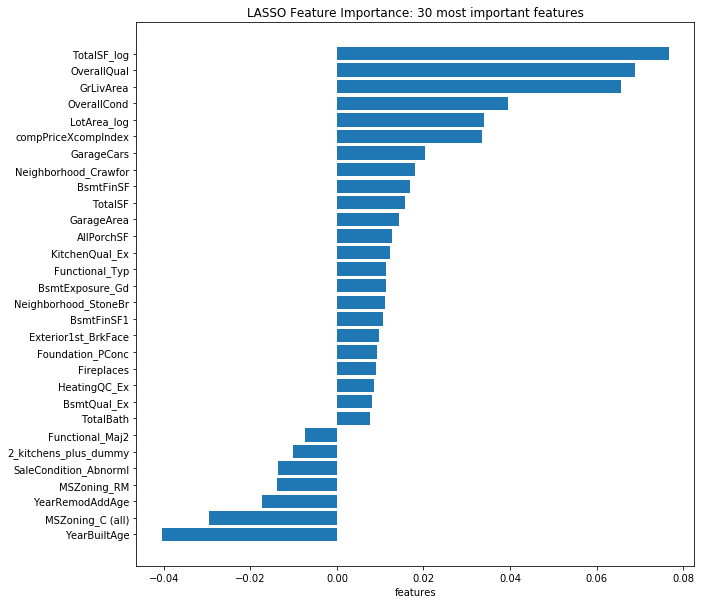

In [7]:
# score on entire training set
print("training set score: {}".format( np.sqrt(mean_squared_error(y,model.predict(X))) ))
lasso_plot_coef(model.best_estimator_,X,n_features=30)

In [8]:
cols=X.columns.tolist()
# all pandas series
coefs = pd.Series(model.best_estimator_.coef_.tolist(),index=cols)
coefs = coefs[coefs!=0]
data = data.loc[:,coefs.index.tolist()]
X = data[:n_train]
X.head()

,PoolArea,OverallCond,OverallQual,BsmtFinSF,ScreenPorch,GarageCars,AllPorchSF,LotArea,5_bedroom_plus_dummy,YearRemodAddAge,...,PoolQC_Gd,RoofMatl_Membran,RoofMatl_WdShngl,SaleCondition_Abnorml,SaleCondition_Family,SaleType_ConLD,SaleType_New,SaleType_WD,Street_Grvl,Utilities_AllPub
0,-0.060437,-0.507416,0.649468,0.466232,-0.285992,0.307685,-0.761751,-0.216400,-0.156776,-0.887744,...,-0.032081,-0.018515,-0.049037,-0.263912,-0.126557,-0.094817,-0.297326,0.393366,-0.06426,0.018515
1,-0.060437,2.186999,-0.061413,1.049193,-0.285992,0.307685,0.721678,-0.069097,-0.156776,0.356886,...,-0.032081,-0.018515,-0.049037,-0.263912,-0.126557,-0.094817,-0.297326,0.393366,-0.06426,0.018515
2,-0.060437,-0.507416,0.649468,-0.005281,-0.285992,0.307685,-0.880675,0.142251,-0.156776,-0.839874,...,-0.032081,-0.018515,-0.049037,-0.263912,-0.126557,-0.094817,-0.297326,0.393366,-0.06426,0.018515
3,-0.060437,-0.507416,0.649468,-0.583956,-0.285992,1.619846,0.778011,-0.075501,-0.156776,0.596238,...,-0.032081,-0.018515,-0.049037,3.787837,-0.126557,-0.094817,-0.297326,0.393366,-0.06426,0.018515
4,-0.060437,-0.507416,1.360350,0.356926,-0.285992,1.619846,0.583976,0.527801,-0.156776,-0.744133,...,-0.032081,-0.018515,-0.049037,-0.263912,-0.126557,-0.094817,-0.297326,0.393366,-0.06426,0.018515


In [9]:
# repeated k-fold
repeatedkfold = RepeatedKFold()
rkf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=2652124)
# LassoCV
lassocv = LassoCV(cv=rkf,n_alphas=100,n_jobs=-1)
# model validation score
def model_validation_score(X,y,model=lassocv,n_split=10,n_repeats=1,msg=False):
    repeatedkfold = RepeatedKFold()
    rkf = RepeatedKFold(n_splits=n_split, n_repeats=n_repeats, random_state=1)
    sample = range(0,X.shape[0])
    train_score = []
    test_score = []
    y_train_lst = []
    y_train_estimated_lst = []
    y_test_lst = []
    y_test_estimated_lst = []
    iteration = 1
    for train_index, test_index in rkf.split(sample):
        if (msg==True): print('iteration {}'.format(iteration))
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        reg = model.fit(X_train,y_train)        
        train_score.append(reg.score(X_train,y_train))
        test_score.append(reg.score(X_test,y_test))
        y_train_lst += y_train.tolist()
        y_test_lst += y_test.tolist()
        y_train_estimated_lst += model.predict(X_train).tolist()
        y_test_estimated_lst += model.predict(X_test).tolist()
        iteration += 1
    train_score = np.sqrt(mean_squared_error(y_train_lst,y_train_estimated_lst))
    test_score = np.sqrt(mean_squared_error(y_test_lst,y_test_estimated_lst))
    if (msg==True):
        print('train root_mean_squared_log_error: {}'.format(train_score))
        print('test root_mean_squared_log_error: {}'.format(test_score))
    return(train_score,test_score)

In [10]:
model_validation_score(X,y,model=lassocv,n_split=10,n_repeats=10,msg=False)

(0.09247022707535052, 0.10557792779844272)

**fit lasso with Keras**

Instructions for updating:
Use tf.cast instead.


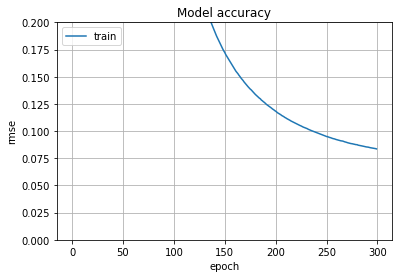

training set score: 0.11312652698333522


In [6]:
# define custom metric
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def rmse(y_true,y_pred):
    return K.sqrt(K.mean(K.square(y_pred-y_true),axis=-1))

NN_model = Sequential()
"""
    Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform', 
          bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, 
          activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
"""
# The Output Layer:
NN_model.add(Dense(1, kernel_initializer='normal', input_dim = X.shape[1], 
                   kernel_regularizer=l1(0.003430469286314919), activation='linear'))
# Compile the network:
sgd = SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
NN_model.compile(loss='mse', optimizer=sgd, metrics=[rmse])
history = NN_model.fit(X, y, epochs=300, batch_size=1000, verbose = 0)
plt.plot(history.history['rmse'])
plt.ylim((0, 0.2))
plt.title('Model accuracy')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper left')
plt.grid(True)
plt.show()
# score on entire training set
print("training set score: {}".format( np.sqrt(mean_squared_error(NN_model.predict(X),y)) ))

**fit deep neural network**

In [64]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(2, kernel_initializer='normal',input_dim = X.shape[1], activation='relu'))
NN_model.add(Dropout(0.2))

NN_model.add(Dense(2, kernel_initializer='normal',input_dim = X.shape[1], activation='relu'))
NN_model.add(Dropout(0.2))


# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network:
sgd = SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=True)
NN_model.compile(loss='mean_absolute_error', optimizer=sgd, metrics=[rmse])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 2)                 676       
_________________________________________________________________
dropout_17 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_49 (Dense)             (None, 2)                 6         
_________________________________________________________________
dropout_18 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 3         
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________


In [65]:
history = NN_model.fit(X, y, batch_size=100, epochs=1000,
              validation_split=0.2, verbose=1, shuffle=True)

Train on 1166 samples, validate on 292 samples
Epoch 1/1000
1166/1166 [==============================] - 1s 875us/step - loss: 11.8069 - rmse: 11.8069 - val_loss: 11.4142 - val_rmse: 11.4142
Epoch 2/1000
1166/1166 [==============================] - 0s 52us/step - loss: 10.9590 - rmse: 10.9590 - val_loss: 10.3780 - val_rmse: 10.3780
Epoch 3/1000
1166/1166 [==============================] - 0s 85us/step - loss: 9.8580 - rmse: 9.8580 - val_loss: 9.2235 - val_rmse: 9.2235
Epoch 4/1000
1166/1166 [==============================] - 0s 43us/step - loss: 8.6840 - rmse: 8.6840 - val_loss: 8.0314 - val_rmse: 8.0314
Epoch 5/1000
1166/1166 [==============================] - 0s 27us/step - loss: 7.4797 - rmse: 7.4797 - val_loss: 6.8075 - val_rmse: 6.8075
Epoch 6/1000
1166/1166 [==============================] - 0s 45us/step - loss: 6.2134 - rmse: 6.2134 - val_loss: 5.4522 - val_rmse: 5.4522
Epoch 7/1000
1166/1166 [==============================] - 0s 44us/step - loss: 4.6086 - rmse: 4.6086 - val_los

Epoch 59/1000
1166/1166 [==============================] - 0s 52us/step - loss: 0.1929 - rmse: 0.1929 - val_loss: 0.1575 - val_rmse: 0.1575
Epoch 60/1000
1166/1166 [==============================] - 0s 33us/step - loss: 0.1812 - rmse: 0.1812 - val_loss: 0.1470 - val_rmse: 0.1470
Epoch 61/1000
1166/1166 [==============================] - 0s 41us/step - loss: 0.1839 - rmse: 0.1839 - val_loss: 0.1502 - val_rmse: 0.1502
Epoch 62/1000
1166/1166 [==============================] - 0s 31us/step - loss: 0.1858 - rmse: 0.1858 - val_loss: 0.1510 - val_rmse: 0.1510
Epoch 63/1000
1166/1166 [==============================] - 0s 23us/step - loss: 0.1765 - rmse: 0.1765 - val_loss: 0.1493 - val_rmse: 0.1493
Epoch 64/1000
1166/1166 [==============================] - 0s 37us/step - loss: 0.1810 - rmse: 0.1810 - val_loss: 0.1536 - val_rmse: 0.1536
Epoch 65/1000
1166/1166 [==============================] - 0s 40us/step - loss: 0.1821 - rmse: 0.1821 - val_loss: 0.1528 - val_rmse: 0.1528
Epoch 66/1000
1166/1

1166/1166 [==============================] - 0s 36us/step - loss: 0.1746 - rmse: 0.1746 - val_loss: 0.1530 - val_rmse: 0.1530
Epoch 118/1000
1166/1166 [==============================] - 0s 35us/step - loss: 0.1776 - rmse: 0.1776 - val_loss: 0.1538 - val_rmse: 0.1538
Epoch 119/1000
1166/1166 [==============================] - 0s 34us/step - loss: 0.1888 - rmse: 0.1888 - val_loss: 0.1456 - val_rmse: 0.1456
Epoch 120/1000
1166/1166 [==============================] - 0s 31us/step - loss: 0.1696 - rmse: 0.1696 - val_loss: 0.1516 - val_rmse: 0.1516
Epoch 121/1000
1166/1166 [==============================] - 0s 51us/step - loss: 0.1847 - rmse: 0.1847 - val_loss: 0.1560 - val_rmse: 0.1560
Epoch 122/1000
1166/1166 [==============================] - 0s 30us/step - loss: 0.1740 - rmse: 0.1740 - val_loss: 0.1524 - val_rmse: 0.1524
Epoch 123/1000
1166/1166 [==============================] - 0s 40us/step - loss: 0.1817 - rmse: 0.1817 - val_loss: 0.1501 - val_rmse: 0.1501
Epoch 124/1000
1166/1166 [==

1166/1166 [==============================] - 0s 38us/step - loss: 0.1658 - rmse: 0.1658 - val_loss: 0.1536 - val_rmse: 0.1536
Epoch 176/1000
1166/1166 [==============================] - 0s 38us/step - loss: 0.1844 - rmse: 0.1844 - val_loss: 0.1530 - val_rmse: 0.1530
Epoch 177/1000
1166/1166 [==============================] - 0s 31us/step - loss: 0.1943 - rmse: 0.1943 - val_loss: 0.1595 - val_rmse: 0.1595
Epoch 178/1000
1166/1166 [==============================] - 0s 32us/step - loss: 0.1789 - rmse: 0.1789 - val_loss: 0.1533 - val_rmse: 0.1533
Epoch 179/1000
1166/1166 [==============================] - 0s 35us/step - loss: 0.1828 - rmse: 0.1828 - val_loss: 0.1493 - val_rmse: 0.1493
Epoch 180/1000
1166/1166 [==============================] - 0s 30us/step - loss: 0.1834 - rmse: 0.1834 - val_loss: 0.1557 - val_rmse: 0.1557
Epoch 181/1000
1166/1166 [==============================] - 0s 42us/step - loss: 0.1760 - rmse: 0.1760 - val_loss: 0.1594 - val_rmse: 0.1594
Epoch 182/1000
1166/1166 [==

1166/1166 [==============================] - 0s 61us/step - loss: 0.1744 - rmse: 0.1744 - val_loss: 0.1549 - val_rmse: 0.1549
Epoch 234/1000
1166/1166 [==============================] - 0s 35us/step - loss: 0.1782 - rmse: 0.1782 - val_loss: 0.1530 - val_rmse: 0.1530
Epoch 235/1000
1166/1166 [==============================] - 0s 39us/step - loss: 0.1785 - rmse: 0.1785 - val_loss: 0.1505 - val_rmse: 0.1505
Epoch 236/1000
1166/1166 [==============================] - 0s 41us/step - loss: 0.1756 - rmse: 0.1756 - val_loss: 0.1519 - val_rmse: 0.1519
Epoch 237/1000
1166/1166 [==============================] - 0s 45us/step - loss: 0.1786 - rmse: 0.1786 - val_loss: 0.1522 - val_rmse: 0.1522
Epoch 238/1000
1166/1166 [==============================] - 0s 42us/step - loss: 0.1787 - rmse: 0.1787 - val_loss: 0.1475 - val_rmse: 0.1475
Epoch 239/1000
1166/1166 [==============================] - 0s 44us/step - loss: 0.1782 - rmse: 0.1782 - val_loss: 0.1572 - val_rmse: 0.1572
Epoch 240/1000
1166/1166 [==

1166/1166 [==============================] - 0s 40us/step - loss: 0.1825 - rmse: 0.1825 - val_loss: 0.1514 - val_rmse: 0.1514
Epoch 292/1000
1166/1166 [==============================] - 0s 51us/step - loss: 0.1774 - rmse: 0.1774 - val_loss: 0.1578 - val_rmse: 0.1578
Epoch 293/1000
1166/1166 [==============================] - 0s 58us/step - loss: 0.1773 - rmse: 0.1773 - val_loss: 0.1540 - val_rmse: 0.1540
Epoch 294/1000
1166/1166 [==============================] - 0s 44us/step - loss: 0.1770 - rmse: 0.1770 - val_loss: 0.1473 - val_rmse: 0.1473
Epoch 295/1000
1166/1166 [==============================] - 0s 32us/step - loss: 0.1788 - rmse: 0.1788 - val_loss: 0.1559 - val_rmse: 0.1559
Epoch 296/1000
1166/1166 [==============================] - 0s 32us/step - loss: 0.1794 - rmse: 0.1794 - val_loss: 0.1480 - val_rmse: 0.1480
Epoch 297/1000
1166/1166 [==============================] - 0s 41us/step - loss: 0.1857 - rmse: 0.1857 - val_loss: 0.1539 - val_rmse: 0.1539
Epoch 298/1000
1166/1166 [==

1166/1166 [==============================] - 0s 39us/step - loss: 0.1781 - rmse: 0.1781 - val_loss: 0.1579 - val_rmse: 0.1579
Epoch 350/1000
1166/1166 [==============================] - 0s 35us/step - loss: 0.1783 - rmse: 0.1783 - val_loss: 0.1559 - val_rmse: 0.1559
Epoch 351/1000
1166/1166 [==============================] - 0s 44us/step - loss: 0.1738 - rmse: 0.1738 - val_loss: 0.1557 - val_rmse: 0.1557
Epoch 352/1000
1166/1166 [==============================] - 0s 37us/step - loss: 0.1696 - rmse: 0.1696 - val_loss: 0.1492 - val_rmse: 0.1492
Epoch 353/1000
1166/1166 [==============================] - 0s 35us/step - loss: 0.1824 - rmse: 0.1824 - val_loss: 0.1614 - val_rmse: 0.1614
Epoch 354/1000
1166/1166 [==============================] - 0s 32us/step - loss: 0.1817 - rmse: 0.1817 - val_loss: 0.1506 - val_rmse: 0.1506
Epoch 355/1000
1166/1166 [==============================] - 0s 54us/step - loss: 0.1751 - rmse: 0.1751 - val_loss: 0.1568 - val_rmse: 0.1568
Epoch 356/1000
1166/1166 [==

1166/1166 [==============================] - 0s 38us/step - loss: 0.1876 - rmse: 0.1876 - val_loss: 0.1463 - val_rmse: 0.1463
Epoch 408/1000
1166/1166 [==============================] - 0s 34us/step - loss: 0.1746 - rmse: 0.1746 - val_loss: 0.1528 - val_rmse: 0.1528
Epoch 409/1000
1166/1166 [==============================] - 0s 27us/step - loss: 0.1795 - rmse: 0.1795 - val_loss: 0.1529 - val_rmse: 0.1529
Epoch 410/1000
1166/1166 [==============================] - 0s 52us/step - loss: 0.1772 - rmse: 0.1772 - val_loss: 0.1573 - val_rmse: 0.1573
Epoch 411/1000
1166/1166 [==============================] - 0s 25us/step - loss: 0.1635 - rmse: 0.1635 - val_loss: 0.1548 - val_rmse: 0.1548
Epoch 412/1000
1166/1166 [==============================] - 0s 43us/step - loss: 0.1739 - rmse: 0.1739 - val_loss: 0.1542 - val_rmse: 0.1542
Epoch 413/1000
1166/1166 [==============================] - 0s 29us/step - loss: 0.1752 - rmse: 0.1752 - val_loss: 0.1507 - val_rmse: 0.1507
Epoch 414/1000
1166/1166 [==

1166/1166 [==============================] - 0s 72us/step - loss: 0.1827 - rmse: 0.1827 - val_loss: 0.1465 - val_rmse: 0.1465
Epoch 466/1000
1166/1166 [==============================] - 0s 63us/step - loss: 0.1791 - rmse: 0.1791 - val_loss: 0.1570 - val_rmse: 0.1570
Epoch 467/1000
1166/1166 [==============================] - 0s 53us/step - loss: 0.1898 - rmse: 0.1898 - val_loss: 0.1546 - val_rmse: 0.1546
Epoch 468/1000
1166/1166 [==============================] - 0s 52us/step - loss: 0.1811 - rmse: 0.1811 - val_loss: 0.1549 - val_rmse: 0.1549
Epoch 469/1000
1166/1166 [==============================] - 0s 39us/step - loss: 0.1780 - rmse: 0.1780 - val_loss: 0.1514 - val_rmse: 0.1514
Epoch 470/1000
1166/1166 [==============================] - 0s 46us/step - loss: 0.1798 - rmse: 0.1798 - val_loss: 0.1565 - val_rmse: 0.1565
Epoch 471/1000
1166/1166 [==============================] - 0s 41us/step - loss: 0.1752 - rmse: 0.1752 - val_loss: 0.1539 - val_rmse: 0.1539
Epoch 472/1000
1166/1166 [==

Epoch 523/1000
1166/1166 [==============================] - 0s 49us/step - loss: 0.1776 - rmse: 0.1776 - val_loss: 0.1547 - val_rmse: 0.1547
Epoch 524/1000
1166/1166 [==============================] - 0s 34us/step - loss: 0.1775 - rmse: 0.1775 - val_loss: 0.1527 - val_rmse: 0.1527
Epoch 525/1000
1166/1166 [==============================] - 0s 32us/step - loss: 0.1852 - rmse: 0.1852 - val_loss: 0.1517 - val_rmse: 0.1517
Epoch 526/1000
1166/1166 [==============================] - 0s 51us/step - loss: 0.1805 - rmse: 0.1805 - val_loss: 0.1547 - val_rmse: 0.1547
Epoch 527/1000
1166/1166 [==============================] - 0s 28us/step - loss: 0.1823 - rmse: 0.1823 - val_loss: 0.1494 - val_rmse: 0.1494
Epoch 528/1000
1166/1166 [==============================] - 0s 44us/step - loss: 0.1726 - rmse: 0.1726 - val_loss: 0.1519 - val_rmse: 0.1519
Epoch 529/1000
1166/1166 [==============================] - 0s 25us/step - loss: 0.1771 - rmse: 0.1771 - val_loss: 0.1548 - val_rmse: 0.1548
Epoch 530/100

1166/1166 [==============================] - 0s 38us/step - loss: 0.1767 - rmse: 0.1767 - val_loss: 0.1547 - val_rmse: 0.1547
Epoch 582/1000
1166/1166 [==============================] - 0s 38us/step - loss: 0.1712 - rmse: 0.1712 - val_loss: 0.1541 - val_rmse: 0.1541
Epoch 583/1000
1166/1166 [==============================] - 0s 37us/step - loss: 0.1789 - rmse: 0.1789 - val_loss: 0.1595 - val_rmse: 0.1595
Epoch 584/1000
1166/1166 [==============================] - 0s 32us/step - loss: 0.1767 - rmse: 0.1767 - val_loss: 0.1476 - val_rmse: 0.1476
Epoch 585/1000
1166/1166 [==============================] - 0s 32us/step - loss: 0.1778 - rmse: 0.1778 - val_loss: 0.1551 - val_rmse: 0.1551
Epoch 586/1000
1166/1166 [==============================] - 0s 38us/step - loss: 0.1796 - rmse: 0.1796 - val_loss: 0.1540 - val_rmse: 0.1540
Epoch 587/1000
1166/1166 [==============================] - 0s 25us/step - loss: 0.1715 - rmse: 0.1715 - val_loss: 0.1514 - val_rmse: 0.1514
Epoch 588/1000
1166/1166 [==

1166/1166 [==============================] - 0s 32us/step - loss: 0.1841 - rmse: 0.1841 - val_loss: 0.1613 - val_rmse: 0.1613
Epoch 640/1000
1166/1166 [==============================] - 0s 38us/step - loss: 0.1804 - rmse: 0.1804 - val_loss: 0.1597 - val_rmse: 0.1597
Epoch 641/1000
1166/1166 [==============================] - 0s 30us/step - loss: 0.1708 - rmse: 0.1708 - val_loss: 0.1537 - val_rmse: 0.1537
Epoch 642/1000
1166/1166 [==============================] - 0s 31us/step - loss: 0.1685 - rmse: 0.1685 - val_loss: 0.1519 - val_rmse: 0.1519
Epoch 643/1000
1166/1166 [==============================] - 0s 36us/step - loss: 0.1692 - rmse: 0.1692 - val_loss: 0.1484 - val_rmse: 0.1484
Epoch 644/1000
1166/1166 [==============================] - 0s 32us/step - loss: 0.1658 - rmse: 0.1658 - val_loss: 0.1556 - val_rmse: 0.1556
Epoch 645/1000
1166/1166 [==============================] - 0s 43us/step - loss: 0.1766 - rmse: 0.1766 - val_loss: 0.1556 - val_rmse: 0.1556
Epoch 646/1000
1166/1166 [==

1166/1166 [==============================] - 0s 38us/step - loss: 0.1768 - rmse: 0.1768 - val_loss: 0.1534 - val_rmse: 0.1534
Epoch 698/1000
1166/1166 [==============================] - 0s 39us/step - loss: 0.1805 - rmse: 0.1805 - val_loss: 0.1551 - val_rmse: 0.1551
Epoch 699/1000
1166/1166 [==============================] - 0s 31us/step - loss: 0.1788 - rmse: 0.1788 - val_loss: 0.1584 - val_rmse: 0.1584
Epoch 700/1000
1166/1166 [==============================] - 0s 33us/step - loss: 0.1789 - rmse: 0.1789 - val_loss: 0.1563 - val_rmse: 0.1563
Epoch 701/1000
1166/1166 [==============================] - 0s 29us/step - loss: 0.1773 - rmse: 0.1773 - val_loss: 0.1532 - val_rmse: 0.1532
Epoch 702/1000
1166/1166 [==============================] - 0s 29us/step - loss: 0.1798 - rmse: 0.1798 - val_loss: 0.1563 - val_rmse: 0.1563
Epoch 703/1000
1166/1166 [==============================] - 0s 37us/step - loss: 0.1780 - rmse: 0.1780 - val_loss: 0.1497 - val_rmse: 0.1497
Epoch 704/1000
1166/1166 [==

1166/1166 [==============================] - 0s 31us/step - loss: 0.1747 - rmse: 0.1747 - val_loss: 0.1586 - val_rmse: 0.1586
Epoch 756/1000
1166/1166 [==============================] - 0s 34us/step - loss: 0.1715 - rmse: 0.1715 - val_loss: 0.1575 - val_rmse: 0.1575
Epoch 757/1000
1166/1166 [==============================] - 0s 37us/step - loss: 0.1713 - rmse: 0.1713 - val_loss: 0.1540 - val_rmse: 0.1540
Epoch 758/1000
1166/1166 [==============================] - 0s 24us/step - loss: 0.1666 - rmse: 0.1666 - val_loss: 0.1584 - val_rmse: 0.1584
Epoch 759/1000
1166/1166 [==============================] - 0s 38us/step - loss: 0.1767 - rmse: 0.1767 - val_loss: 0.1484 - val_rmse: 0.1484
Epoch 760/1000
1166/1166 [==============================] - 0s 29us/step - loss: 0.1741 - rmse: 0.1741 - val_loss: 0.1557 - val_rmse: 0.1557
Epoch 761/1000
1166/1166 [==============================] - 0s 34us/step - loss: 0.1900 - rmse: 0.1900 - val_loss: 0.1564 - val_rmse: 0.1564
Epoch 762/1000
1166/1166 [==

1166/1166 [==============================] - 0s 31us/step - loss: 0.1801 - rmse: 0.1801 - val_loss: 0.1514 - val_rmse: 0.1514
Epoch 814/1000
1166/1166 [==============================] - 0s 38us/step - loss: 0.1798 - rmse: 0.1798 - val_loss: 0.1536 - val_rmse: 0.1536
Epoch 815/1000
1166/1166 [==============================] - 0s 32us/step - loss: 0.1804 - rmse: 0.1804 - val_loss: 0.1544 - val_rmse: 0.1544
Epoch 816/1000
1166/1166 [==============================] - 0s 26us/step - loss: 0.1882 - rmse: 0.1882 - val_loss: 0.1563 - val_rmse: 0.1563
Epoch 817/1000
1166/1166 [==============================] - 0s 41us/step - loss: 0.1799 - rmse: 0.1799 - val_loss: 0.1575 - val_rmse: 0.1575
Epoch 818/1000
1166/1166 [==============================] - 0s 37us/step - loss: 0.1803 - rmse: 0.1803 - val_loss: 0.1538 - val_rmse: 0.1538
Epoch 819/1000
1166/1166 [==============================] - 0s 28us/step - loss: 0.1738 - rmse: 0.1738 - val_loss: 0.1594 - val_rmse: 0.1594
Epoch 820/1000
1166/1166 [==

1166/1166 [==============================] - 0s 34us/step - loss: 0.1932 - rmse: 0.1932 - val_loss: 0.1576 - val_rmse: 0.1576
Epoch 872/1000
1166/1166 [==============================] - 0s 38us/step - loss: 0.1782 - rmse: 0.1782 - val_loss: 0.1554 - val_rmse: 0.1554
Epoch 873/1000
1166/1166 [==============================] - 0s 35us/step - loss: 0.1745 - rmse: 0.1745 - val_loss: 0.1543 - val_rmse: 0.1543
Epoch 874/1000
1166/1166 [==============================] - 0s 31us/step - loss: 0.1708 - rmse: 0.1708 - val_loss: 0.1602 - val_rmse: 0.1602
Epoch 875/1000
1166/1166 [==============================] - 0s 41us/step - loss: 0.1920 - rmse: 0.1920 - val_loss: 0.1539 - val_rmse: 0.1539
Epoch 876/1000
1166/1166 [==============================] - 0s 42us/step - loss: 0.1728 - rmse: 0.1728 - val_loss: 0.1578 - val_rmse: 0.1578
Epoch 877/1000
1166/1166 [==============================] - 0s 30us/step - loss: 0.1729 - rmse: 0.1729 - val_loss: 0.1586 - val_rmse: 0.1586
Epoch 878/1000
1166/1166 [==

1166/1166 [==============================] - 0s 31us/step - loss: 0.1770 - rmse: 0.1770 - val_loss: 0.1539 - val_rmse: 0.1539
Epoch 930/1000
1166/1166 [==============================] - 0s 40us/step - loss: 0.1778 - rmse: 0.1778 - val_loss: 0.1561 - val_rmse: 0.1561
Epoch 931/1000
1166/1166 [==============================] - 0s 32us/step - loss: 0.1772 - rmse: 0.1772 - val_loss: 0.1538 - val_rmse: 0.1538
Epoch 932/1000
1166/1166 [==============================] - 0s 28us/step - loss: 0.1665 - rmse: 0.1665 - val_loss: 0.1549 - val_rmse: 0.1549
Epoch 933/1000
1166/1166 [==============================] - 0s 39us/step - loss: 0.1749 - rmse: 0.1749 - val_loss: 0.1592 - val_rmse: 0.1592
Epoch 934/1000
1166/1166 [==============================] - 0s 42us/step - loss: 0.1858 - rmse: 0.1858 - val_loss: 0.1534 - val_rmse: 0.1534
Epoch 935/1000
1166/1166 [==============================] - 0s 48us/step - loss: 0.1797 - rmse: 0.1797 - val_loss: 0.1551 - val_rmse: 0.1551
Epoch 936/1000
1166/1166 [==

Epoch 987/1000
1166/1166 [==============================] - 0s 38us/step - loss: 0.1884 - rmse: 0.1884 - val_loss: 0.1513 - val_rmse: 0.1513
Epoch 988/1000
1166/1166 [==============================] - 0s 35us/step - loss: 0.1750 - rmse: 0.1750 - val_loss: 0.1552 - val_rmse: 0.1552
Epoch 989/1000
1166/1166 [==============================] - 0s 49us/step - loss: 0.1853 - rmse: 0.1853 - val_loss: 0.1584 - val_rmse: 0.1584
Epoch 990/1000
1166/1166 [==============================] - 0s 20us/step - loss: 0.1846 - rmse: 0.1846 - val_loss: 0.1508 - val_rmse: 0.1508
Epoch 991/1000
1166/1166 [==============================] - 0s 23us/step - loss: 0.1769 - rmse: 0.1769 - val_loss: 0.1548 - val_rmse: 0.1548
Epoch 992/1000
1166/1166 [==============================] - 0s 56us/step - loss: 0.1768 - rmse: 0.1768 - val_loss: 0.1542 - val_rmse: 0.1542
Epoch 993/1000
1166/1166 [==============================] - 0s 50us/step - loss: 0.1845 - rmse: 0.1845 - val_loss: 0.1561 - val_rmse: 0.1561
Epoch 994/100

**plot loss function and accuracy**

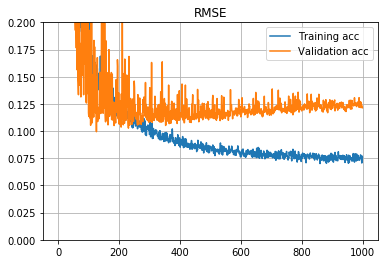

<Figure size 432x288 with 0 Axes>

In [22]:
def plot_perf(history):
    acc = history.history['rmse']
    val_acc = history.history['val_rmse']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('RMSE')
    plt.legend()
    plt.grid(True)
    plt.ylim((0, 0.2))
    plt.figure()

    #plt.plot(epochs, loss, label='Training loss')
    #plt.plot(epochs, val_loss, label='Validation loss')
    #plt.title('RMSE')
    #plt.legend()
    #plt.grid(True)
    #plt.ylim((0, 0.2))
    #plt.show()
# plot loss and accuracy
plot_perf(history)